In [138]:
import os
import numpy as np
import glob
from tqdm import tqdm
import copy
from skimage.feature import canny
from skimage.transform import resize
import pandas as pd
import seaborn as sns
import nibabel as nib
import SimpleITK as sitk

# from torchinfo import summary

import torch
import torch.nn as nn
from torch.utils.data import DataLoader
import torchio as tio
import networks_gan
import losses
from skimage.metrics import structural_similarity as ssim
from dataloader import RadOncTrainingDataset, RadOncValidationDataset, RadOncSynthesisDataset, headscanner_training_dataset, headscanner_validation_dataset
import surface_distance
from helpers import compute_surface_metrics, compute_TRE
os.environ['VXM_BACKEND'] = 'pytorch'
import voxelmorph as vxm  # nopep8

import matplotlib.pyplot as plt
from matplotlib import colors as mplcolors
from matplotlib.collections import LineCollection
def colormap_binary(fg, bg=(0,0,0), alpha=None):
    fg = mplcolors.to_rgb(fg)
    bg = mplcolors.to_rgb(bg)
    cmap = mplcolors.LinearSegmentedColormap.from_list('Binary', (bg,fg), 256)
    if alpha is not None:
        cmap._init()
        cmap._lut[:,-1] = np.linspace(0, alpha, cmap.N+3)
    return cmap
from mpl_toolkits.axes_grid1 import make_axes_locatable
plt.style.use('dark_background')

### Normalize images using Runze's code

In [118]:
from helpers import normalizeImage
def thres_cbct(src, dst):
    n = nib.load(src)
    data = n.get_fdata()
    print(data.max(), data.min())
    data_thresholded = data
    data_thresholded[data_thresholded<-100] = -100
    data_thresholded[data_thresholded>100] = -100
    newdata = (data-(-100))/200
#     print(newdata)
    n_out = nib.Nifti1Image(newdata, n.affine, n.header)
    # n_out.header = n.header.copy()
    n_out.to_filename(dst)
    
def thres_mr(mr):
    m,M = np.percentile(mr,[1,99])
    data_thresholded = mr
    data_thresholded = np.clip((mr-m)/(M-m),0,1)
    return data_thresholded
# Read data
cbct_n = nib.load('inputs_clnc2/V018/Postop_CBCT_resample_crop.nii.gz')
cbct = cbct_n.get_fdata()
print(cbct.max(),cbct.min())
mr_gt_n = nib.load('inputs_clnc2/V018/Postop_MR_resample_crop.nii.gz')
mr_gt= mr_gt_n.get_fdata()
print(mr_gt.max(),mr_gt.min())
mr_n = nib.load('inputs_clnc2/V018/Preop_MR_resample_crop.nii.gz')
mr = mr_n.get_fdata()
print(mr.max(),mr.min())
ct_n = nib.load('inputs_clnc2/V018/Postop_CT_resample_crop.nii.gz')
ct = ct_n.get_fdata()
print(ct.max(),ct.min())

CT_min = -100.0
CT_max = 100.0
CBCT_min = 100
CBCT_max = 300
T1_min = -100.0 ##?
T1_max = 1200.0 ## ?
# cbct = normalizeImage(cbct, CBCT_max, CBCT_min)
# # mr = normalizeImage(mr, T1_max, T1_min)
# # mr_gt = normalizeImage(mr_gt, 2300, T1_min)
# mr = thres_mr(mr)
# mr_gt = thres_mr(mr_gt)




3698.9072265625 -1556.88623046875
819.0 0.0
677.0 0.0
16557.212890625 -3431.568359375


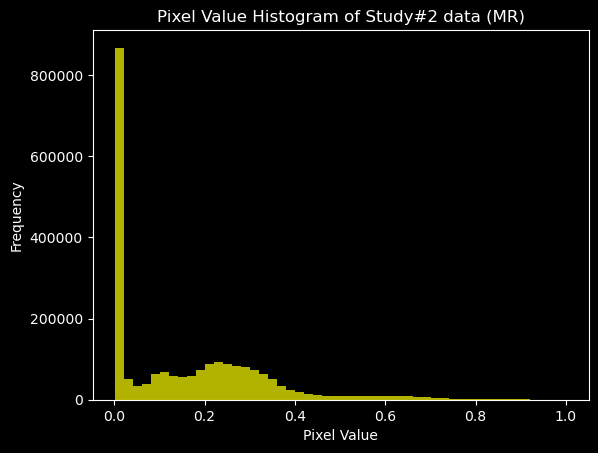

In [91]:
mr_i = np.interp(mr,[0,600],[0,1])

pix_mr = mr_i.flatten()
pix_mr = pix_mr[pix_mr>0]

plt.hist(pix_mr, bins=50, color='yellow', alpha=0.7)
plt.title('Pixel Value Histogram of Study#2 data (MR)')
plt.xlabel('Pixel Value')
plt.ylabel('Frequency')
plt.show()

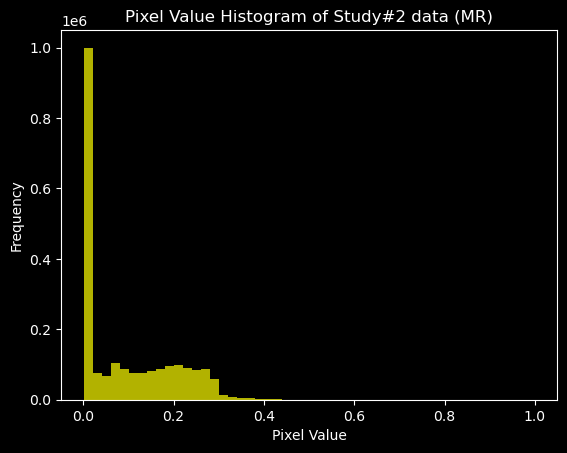

In [123]:
mr_gt_i = np.interp(mr_gt,[0,800],[0,1])

pix_mr_gt = mr_gt_i.flatten()
pix_mr_gt = pix_mr_gt[pix_mr_gt>0]

plt.hist(pix_mr_gt, bins=50, color='yellow', alpha=0.7)
plt.title('Pixel Value Histogram of Study#2 data (MR)')
plt.xlabel('Pixel Value')
plt.ylabel('Frequency')
plt.show()

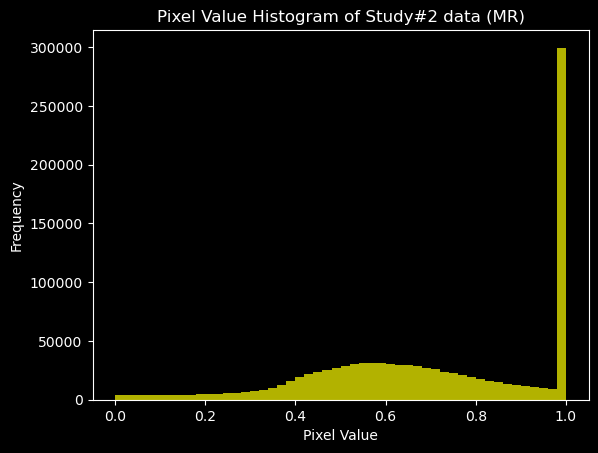

In [92]:
cbct_i = np.interp(cbct,[-200,100],[0,1])

pix_cbct = cbct_i.flatten()
pix_cbct = pix_cbct[pix_cbct>0]

plt.hist(pix_cbct, bins=50, color='yellow', alpha=0.7)
plt.title('Pixel Value Histogram of Study#2 data (MR)')
plt.xlabel('Pixel Value')
plt.ylabel('Frequency')
plt.show()

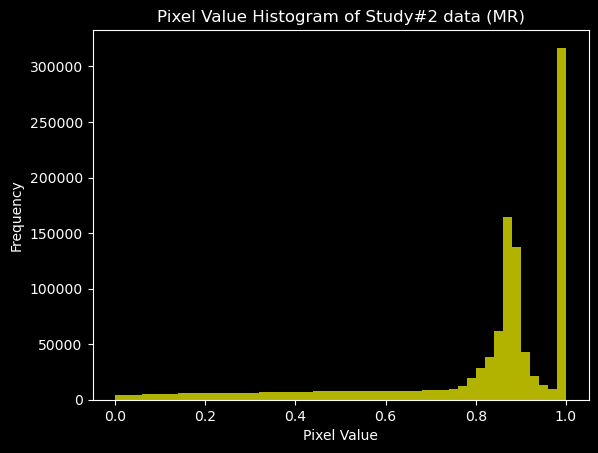

In [135]:
ct_i = np.interp(ct,[-100,200],[0,1])
pix_ct = ct_i.flatten()
pix_ct = pix_ct[pix_ct>0]

plt.hist(pix_ct, bins=50, color='yellow', alpha=0.7)
plt.title('Pixel Value Histogram of Study#2 data (MR)')
plt.xlabel('Pixel Value')
plt.ylabel('Frequency')
plt.show()

In [97]:
norm_out_cbct = 'inputs_clnc2/V018/Postop_CBCT_resampled_crop_norm.nii.gz'
norm_out_ct = 'inputs_clnc2/V018/Postop_CT_resampled_crop_norm.nii.gz'
norm_out_mrpre = 'inputs_clnc2/V018/Preop_MR_resampled_crop_norm.nii.gz'
# norm_out_mrpost = 'inputs_clnc2/V016/Post_MR_resampled_crop_norm.nii.gz'

nib.Nifti1Image(cbct_i, cbct_n.affine,cbct_n.header).to_filename(norm_out_cbct)
nib.Nifti1Image(ct_i, ct_n.affine,ct_n.header).to_filename(norm_out_ct)
nib.Nifti1Image(mr_i, mr_n.affine,mr_n.header).to_filename(norm_out_mrpre)
# nib.Nifti1Image(mr_gt_i, mr_gt_n.affine,mr_gt_n.header).to_filename(norm_out_mrpost)

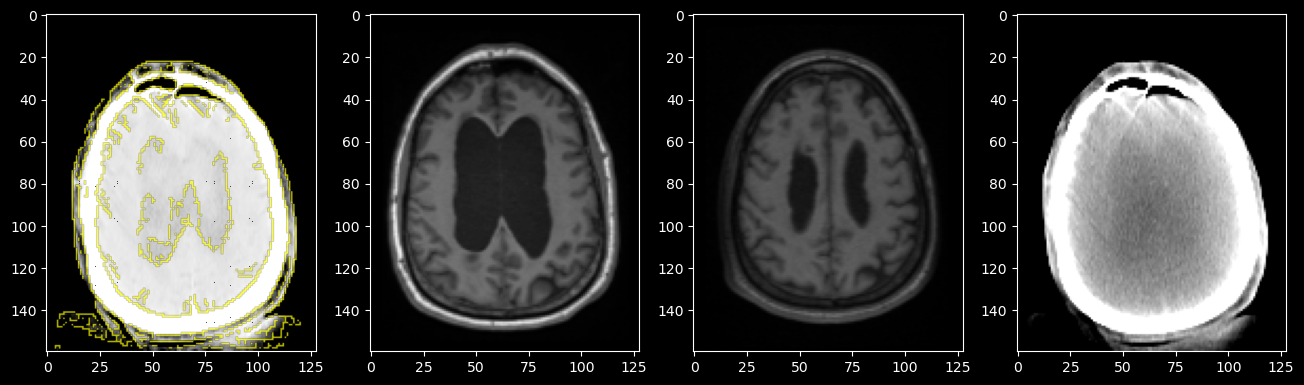

In [136]:
fig, ax = plt.subplots(1,4,figsize = (16,24))
# ax[0].imshow(np.flipud(cbct[:,:,70].T), cmap='gray', clim=np.percentile(cbct, (75,93)))
ax[0].imshow(np.flipud(ct_i[:,:,76].T), cmap='gray', vmin = 0.2, vmax = 0.95)
ax[0].imshow(np.flipud(canny(ct_i[:,:,76].T, sigma=0.005)), cmap=colormap_binary('yellow', alpha=0.7))
ax[1].imshow(np.flipud(mr_i[:,:,76].T), cmap='gray',vmin = 0,vmax = 0.8)
ax[2].imshow(np.flipud(mr_gt_i[:,:,76].T), cmap='gray',vmin = 0,vmax = 0.8 )
ax[3].imshow(np.flipud(cbct_i[:,:,76].T), cmap='gray', )

In [69]:
def command_iteration(method):
    print(
        f"{method.GetOptimizerIteration():3} "
        + f"= {method.GetMetricValue():10.5f} "
        + f": {method.GetOptimizerPosition()}"
    )
    
##fixed is cbct and moving is mr
def registration(fixed_src, moving_src, registered_dst):

    fixed = sitk.ReadImage(fixed_src, sitk.sitkFloat32)##ct
    moving = sitk.ReadImage(moving_src, sitk.sitkFloat32)
    min = sitk.GetArrayFromImage(moving).min()
    numberOfBins = 50
    samplingPercentage = 0.1

    tx = sitk.CenteredTransformInitializer(
        fixed, moving, sitk.Euler3DTransform(),sitk.CenteredTransformInitializerFilter.GEOMETRY)
    # sitk.WriteTransform(tx, "euler2D_initial.tfm")


    R = sitk.ImageRegistrationMethod()


    pixelType = sitk.sitkFloat32

    R.SetMetricAsCorrelation()

    R.SetOptimizerAsRegularStepGradientDescent(
        learningRate=1.0,
        minStep=0.001,
        numberOfIterations=1500,
        gradientMagnitudeTolerance=1e-8,
    )
    # R.SetOptimizerScalesFromIndexShift()
    R.SetOptimizerScalesFromPhysicalShift()

    R.SetInitialTransform(tx)



    ##some tricks
    R.SetMetricAsMattesMutualInformation(numberOfBins)
    R.SetShrinkFactorsPerLevel([4,2,1])
    R.SetSmoothingSigmasPerLevel( [4,2,1] )
    R.SetMetricSamplingPercentage(samplingPercentage, sitk.sitkWallClock)
    R.SetMetricSamplingStrategy(R.RANDOM)
    # R.SetOptimizerAsRegularStepGradientDescent(5.0, 0.001, 500)
    # R.SetInitialTransform(sitk.TranslationTransform(fixed.GetDimension()))
    R.SetInterpolator(sitk.sitkLinear)

    R.AddCommand(sitk.sitkIterationEvent, lambda: command_iteration(R))

    outTx = R.Execute(fixed, moving)

    # print("-------")
    # print(outTx)
    # print(f"Optimizer stop condition: {R.GetOptimizerStopConditionDescription()}")
    # print(f" Iteration: {R.GetOptimizerIteration()}")
    # print(f" Metric value: {R.GetMetricValue()}")

##  whether to save the transformation
#     sitk.WriteTransform(outTx, "euler2D.tfm")

    if "SITK_NOSHOW" not in os.environ:
        resampler = sitk.ResampleImageFilter()
        resampler.SetReferenceImage(fixed)
        resampler.SetInterpolator(sitk.sitkLinear)
        # resampler.SetDefaultPixelValue(1)
        resampler.SetDefaultPixelValue(0)

        resampler.SetTransform(tx)

        out = resampler.Execute(moving)
        simg1 = sitk.Cast(sitk.RescaleIntensity(fixed), sitk.sitkUInt8)
        simg2 = sitk.Cast(sitk.RescaleIntensity(out), sitk.sitkUInt8)
        # simg1 = fixed
        # simg2 = out
        cimg = sitk.Compose(simg1, simg2, simg1 // 2.0 + simg2 // 2.0)
        # cimg = simg2


    ##whether to view the result
    #     image_viewer = sitk.ImageViewer()
    #     image_viewer.SetApplication('E://zli//workspace//Fiji.app//ImageJ-win64')
    #     image_viewer.SetTitle('MR image')
    #     image_viewer.Execute(cimg)

    ##cimg
    print(sitk.GetArrayFromImage(simg2).max())
    sitk.WriteImage(simg2,registered_dst)

    print(fixed.GetPixelIDValue())
    print(fixed.GetDimension())

In [125]:
rigid_mrpre = 'inputs_clnc2/V018/Pre_MR_resampled_crop_norm_rigid.nii.gz'
rigid_mrpost = 'inputs_clnc2/V018/Post_MR_resampled_crop_norm_rigid.nii.gz'
registration(norm_out_cbct, norm_out_mrpre, rigid_mrpre)
registration(norm_out_cbct, norm_out_mrpost, rigid_mrpost)

  0 =   -0.50822 : (-0.0007702456542081832, 0.00020561768185485804, -0.0012110750083089825, -128.25764687834027, -119.60046751272587, -85.80993703956571)
  1 =   -0.52093 : (-0.0013892039147277008, 0.0013417682179465806, -0.0023033450349055572, -128.52150163227415, -120.45918985082126, -85.37064926614003)
  2 =   -0.53317 : (-0.0018655233787760832, 0.0024994226330436395, -0.003576877019519195, -128.5020105101262, -121.27734676665149, -84.79598748012248)
  3 =   -0.54349 : (-0.00203803942050465, 0.004298325059330845, -0.005079270459689472, -128.76647944912017, -122.04429544479217, -84.21131630552267)
  4 =   -0.55580 : (-0.0024967925398112255, 0.006216855992319089, -0.006753809549649977, -128.9622849187745, -122.95917535616614, -83.85826068593666)
  5 =   -0.56751 : (-0.0034251228813625976, 0.0077904946258888184, -0.008724630009520761, -129.0347838299596, -123.9186651145393, -83.58601798321547)
  6 =   -0.57981 : (-0.003764323785537038, 0.009645835317743379, -0.010337590907287735, -129.

1.0 0.0
1.0 0.0
1.0 0.0


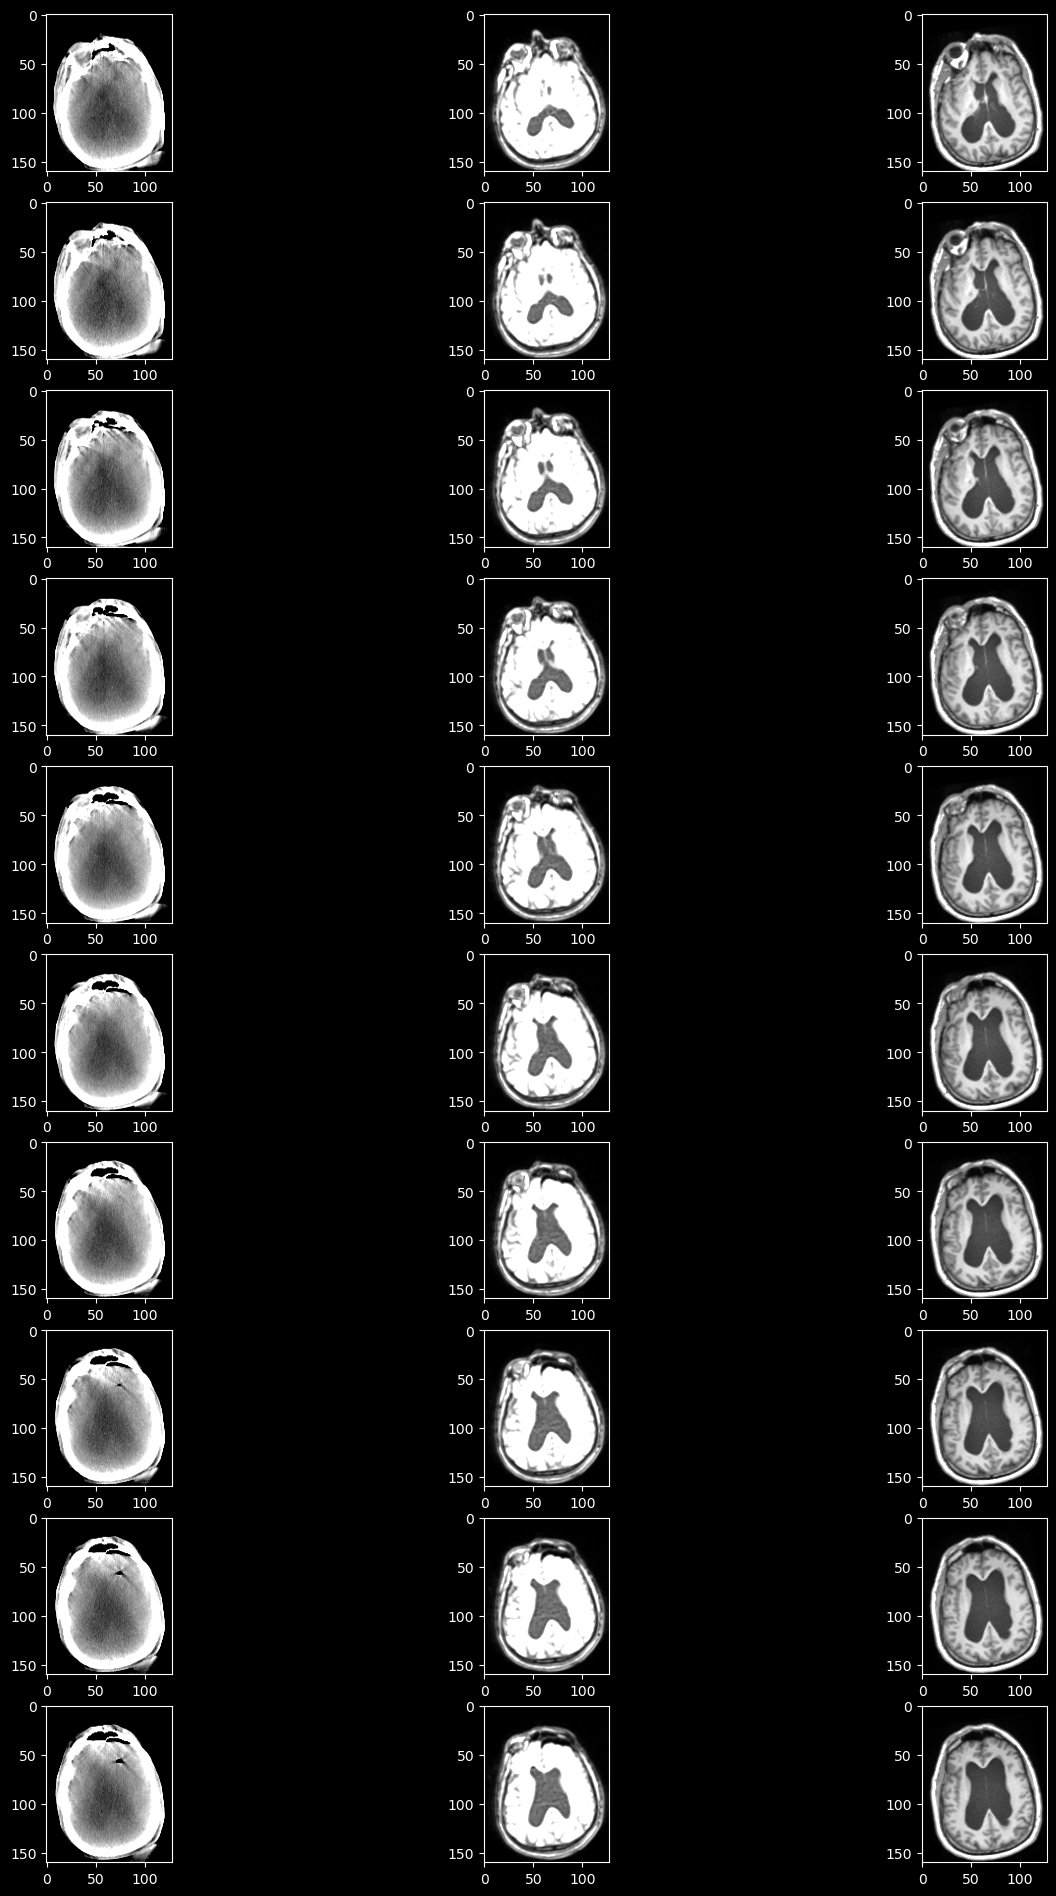

In [126]:
norm_out_cbct = 'inputs_clnc2/V020/post_CBCT_resampled_crop.nii.gz'
rigid_mrpre = 'inputs_clnc2/V020/Pre_MR_resampled_crop_norm_rigid.nii.gz'
rigid_mrpost = 'inputs_clnc2/V020/Postop_MR_resampled_crop_norm_rigid.nii.gz'
ct_path = 'inputs_clnc2/V020/Postop_CBCT_resampled_crop_norm.nii.gz'
ct_i = nib.load(ct_path).get_fdata()

cbct = nib.load(norm_out_cbct).get_fdata()
print(cbct.max(),cbct.min())
mr = nib.load(rigid_mrpost).get_fdata()/255*mr_gt_i.max()
print(mr.max(),mr.min())
mr_pre = nib.load(rigid_mrpre).get_fdata()/255*mr_i.max()
print(mr_pre.max(),mr_pre.min())
islice = 60
fig, ax = plt.subplots(10,3,figsize = (16,24))
for i in range(10):
# ax[0].imshow(np.flipud(cbct[:,:,70].T), cmap='gray', clim=np.percentile(cbct, (75,93)))
    ax[i,0].imshow(np.flipud(cbct[:,:,islice+i].T), cmap='gray', vmin = 0.2, vmax = 0.95)
    ax[i,1].imshow(np.flipud(mr[:,:,islice+i].T), cmap='gray',vmin = 0, vmax = 0.4)
    ax[i,2].imshow(np.flipud(mr_pre[:,:,islice+i].T), cmap='gray',vmin = 0, vmax = 0.4)

In [20]:
device = 'cpu'
G = networks_gan.JSRCascade(separate_decoders=True, res=True, version='v3').to(device)
checkpoint = torch.load('JSRCascade_l1100_multi0.3_reg100_seg0_ep109.pt', map_location=torch.device('cpu'))
G.load_state_dict(checkpoint['G_state_dict'])

/home/myi16/anaconda3/envs/jsr_Y/lib/python3.9/site-packages/torch/functional.py:478: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at  ../aten/src/ATen/native/TensorShape.cpp:2895.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


<All keys matched successfully>

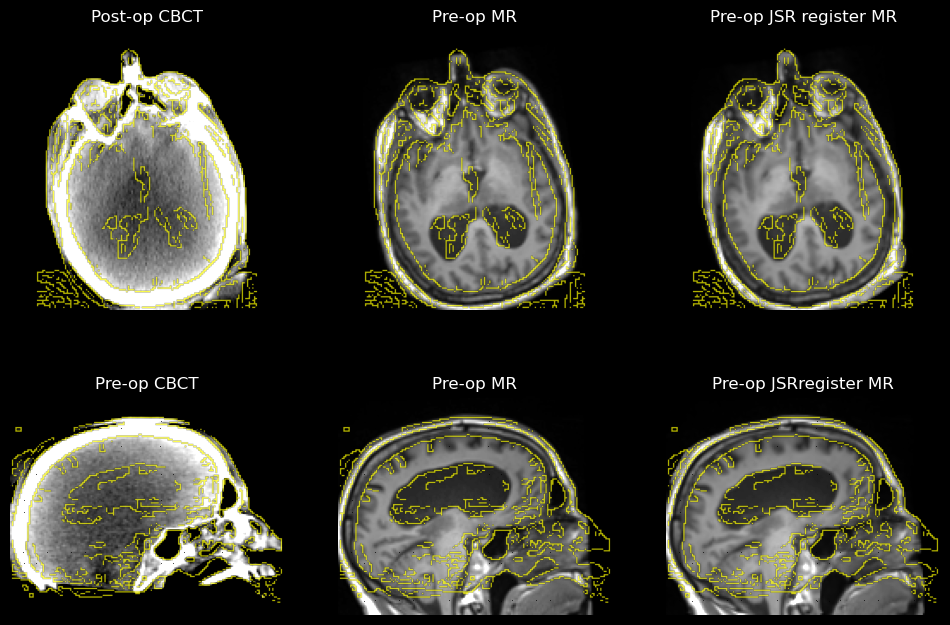

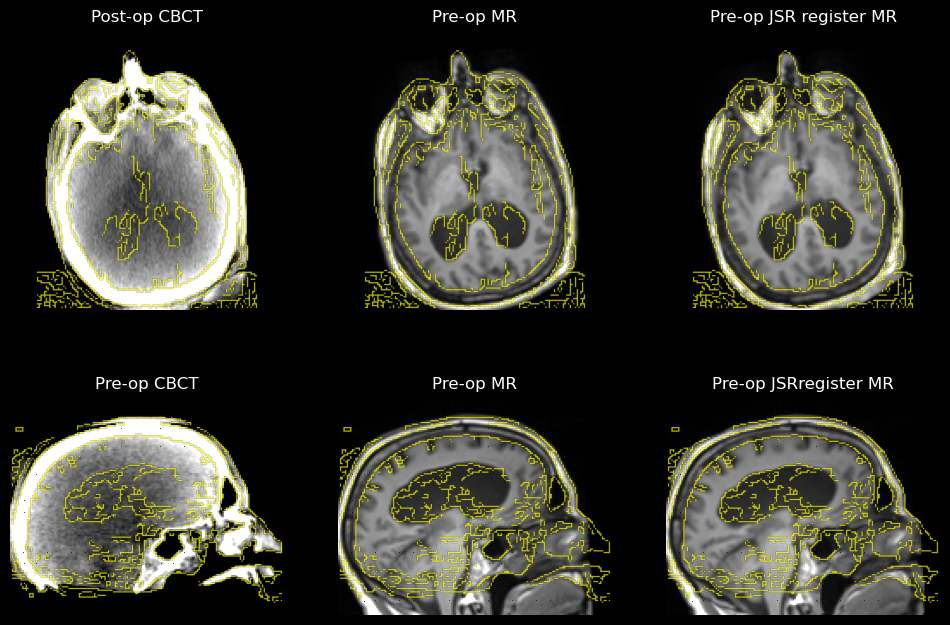

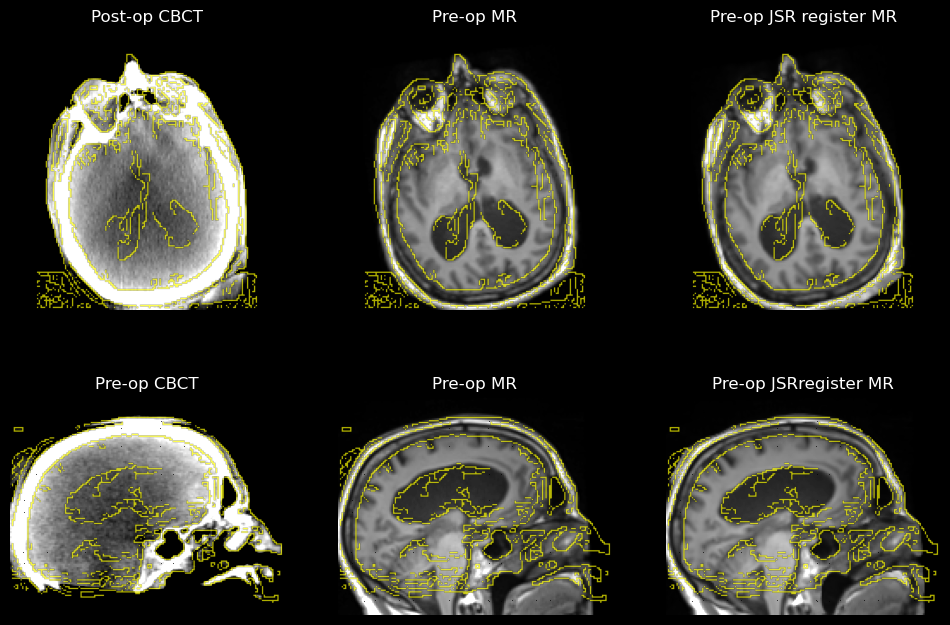

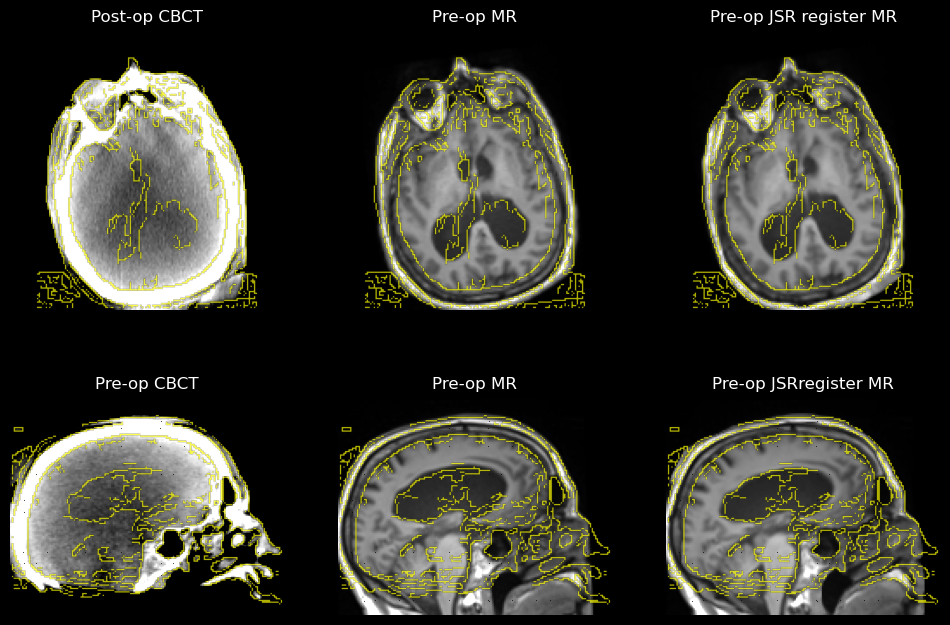

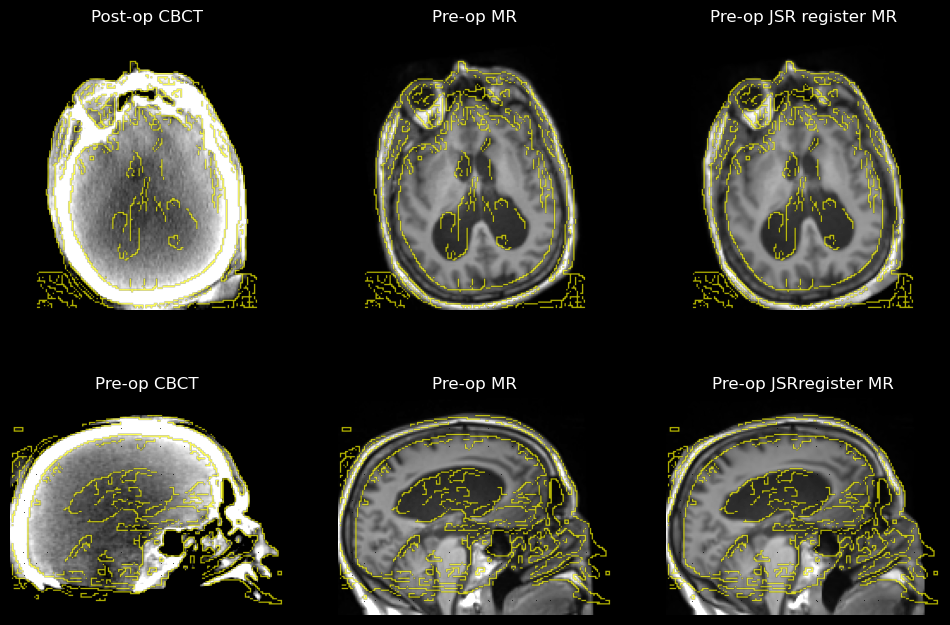

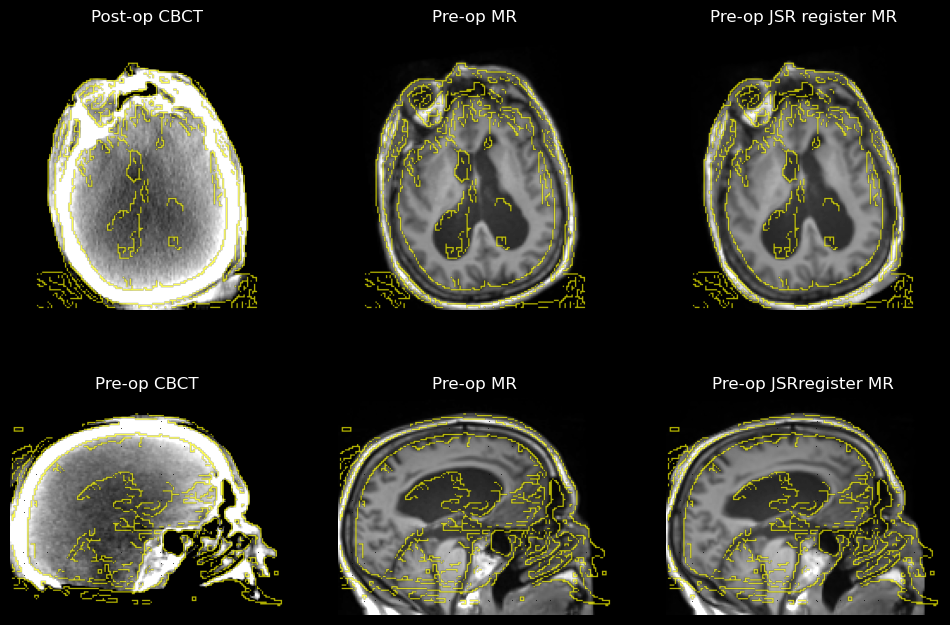

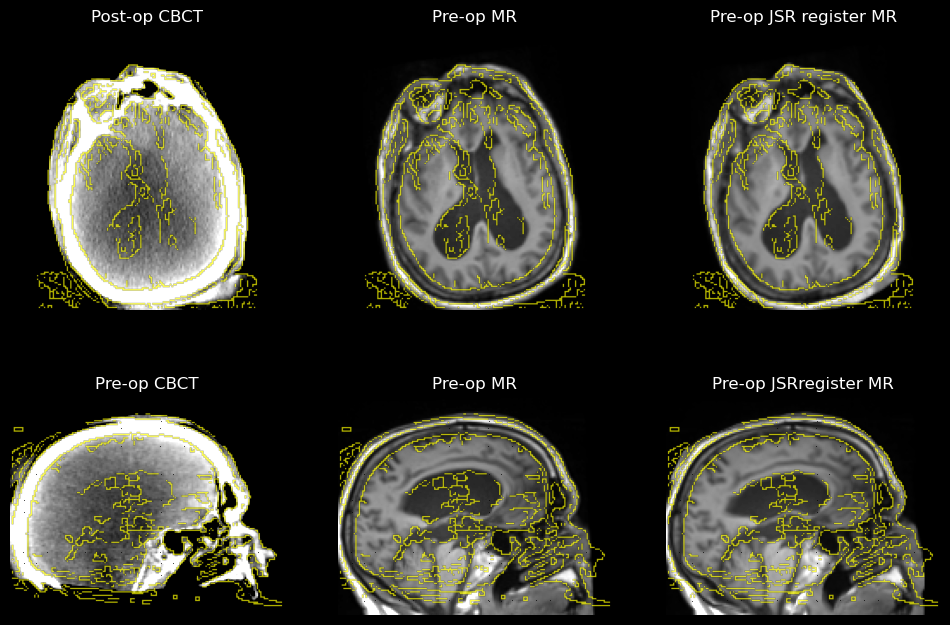

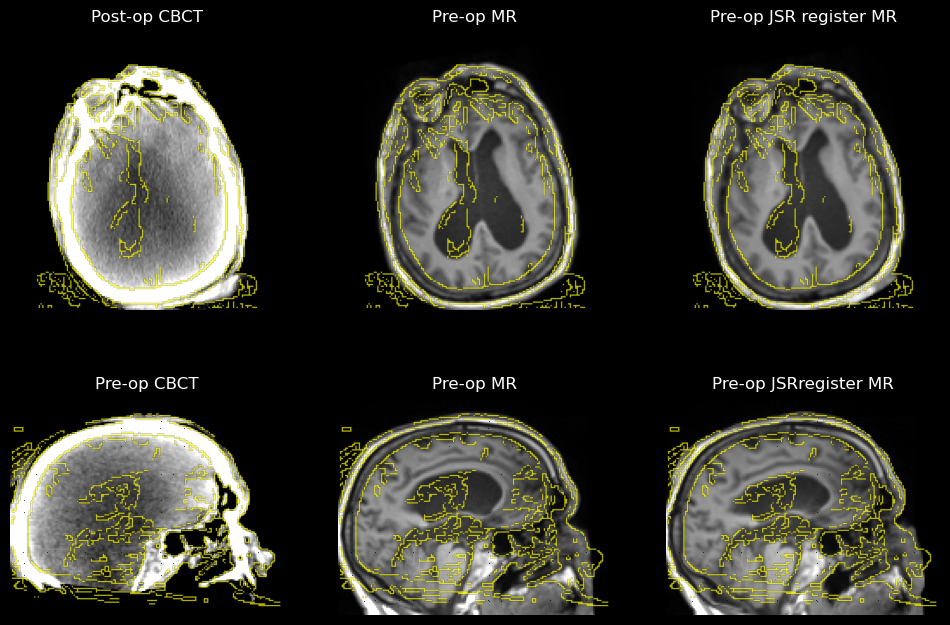

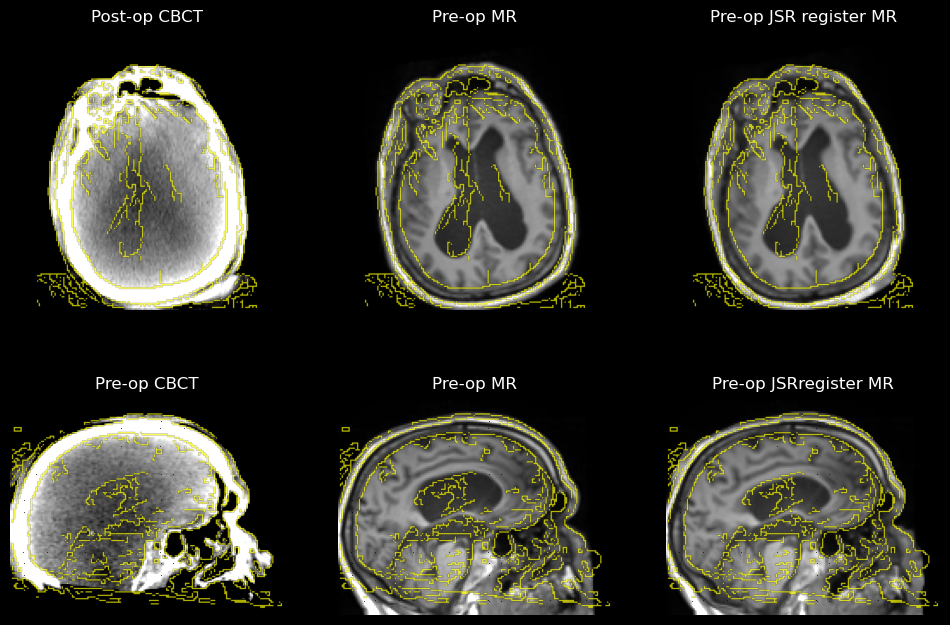

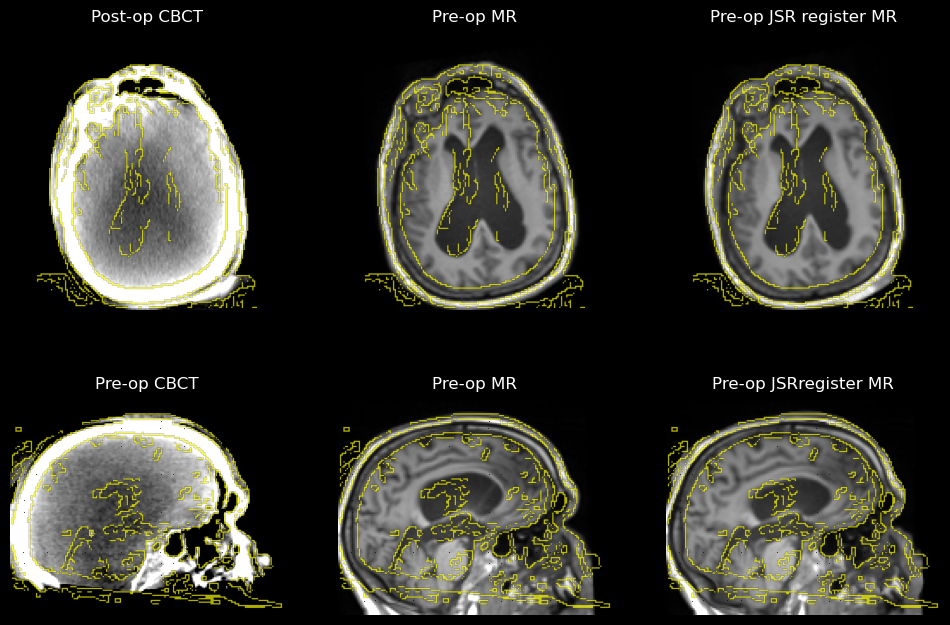

In [139]:
cbct_fixed = torch.from_numpy(cbct).float().unsqueeze(0).unsqueeze(0).to(device)
mr_moving = torch.from_numpy(mr_pre).float().unsqueeze(0).unsqueeze(0).to(device)

with torch.no_grad():
    flow, ct_moving_synth, ct_fixed_synth= G(mr_moving, cbct_fixed)
    mr_reg = vxm.layers.SpatialTransformer([128,160,128], mode='bilinear').to(device)(mr_moving, flow[0])


for i in range(10):
    islice = 55+i
    fig, ax = plt.subplots(2,3,figsize=(12,8))
    np.vectorize(lambda ax: ax.axis('off'))(ax)

    ax[0, 0].imshow(torch.flipud(cbct_fixed[0,0,:,:,islice].T), cmap='gray', vmin=0.2, vmax=0.95)
    ax[0, 0].imshow(canny(np.flipud(ct_i[:,:,islice].T), sigma=0.005), cmap=colormap_binary('yellow', alpha=0.7))
    ax[0, 0].set_title('Post-op CBCT')

    ax[0, 1].imshow(torch.flipud(mr_moving[0,0,:,:,islice].T), cmap='gray', vmin=0, vmax=0.6)
    ax[0, 1].imshow(canny(np.flipud(ct_i[:,:,islice].T), sigma=0.005), cmap=colormap_binary('yellow', alpha=0.7))
    ax[0, 1].set_title('Pre-op MR')

    ax[0, 2].imshow(torch.flipud(mr_reg[0,0,:,:,islice].T), cmap='gray', vmin=0, vmax=0.6)
    ax[0, 2].imshow(canny(np.flipud(ct_i[:,:,islice].T), sigma=0.005), cmap=colormap_binary('yellow', alpha=0.7))
    ax[0, 2].set_title('Pre-op JSR register MR')

    ax[1, 0].imshow(torch.flipud(cbct_fixed[0,0,islice,:,:].T), cmap='gray', vmin=0.2, vmax=0.95)
    ax[1, 0].imshow(canny(np.flipud(ct_i[islice,:,:].T), sigma=0.005), cmap=colormap_binary('yellow', alpha=0.7))
    ax[1, 0].set_title('Pre-op CBCT')

    ax[1, 1].imshow(torch.flipud(mr_moving[0,0,islice,:,:].T), cmap='gray', vmin=0, vmax=0.6)
    ax[1, 1].imshow(np.flipud(canny(ct_i[islice,:,:].T, sigma=0.005)), cmap=colormap_binary('yellow', alpha=0.7))
    ax[1, 1].set_title('Pre-op MR')

    ax[1, 2].imshow(torch.flipud(mr_reg[0,0,islice,:,:].T), cmap='gray', vmin=0, vmax=0.6)
    ax[1, 2].imshow(np.flipud(canny(ct_i[islice,:,:].T, sigma=0.005)), cmap=colormap_binary('yellow', alpha=0.7))
    ax[1, 2].set_title('Pre-op JSRregister MR')
    

pred = flow[0]
fig,ax = plt.subplots(1,3,figsize = (16,24))
im1 = ax[0].imshow(pred[0,0,:,:,islice].T,cmap = 'bwr',vmin = -3,vmax = 3)
divider = make_axes_locatable(ax[0])
cax = divider.append_axes('right', size='5%', pad=0.05)
fig.colorbar(im1, cax=cax, orientation='vertical')
im2 = ax[1].imshow(pred[0,1,:,:,islice].T,cmap = 'bwr',vmin = -3,vmax = 3)
divider = make_axes_locatable(ax[1])
cax = divider.append_axes('right', size='5%', pad=0.05)
fig.colorbar(im2, cax=cax, orientation='vertical')
im3 = ax[2].imshow(pred[0,2,:,:,islice].T,cmap = 'bwr',vmin = -3,vmax = 3)
divider = make_axes_locatable(ax[2])
cax = divider.append_axes('right', size='5%', pad=0.05)
fig.colorbar(im2, cax=cax, orientation='vertical')

In [16]:
print('cbct:',cbct_fixed.dtype)
print('mr:',mr_moving.dtype)
print('ct_fixed:',ct_fixed.dtype)
print('ct_moving:',ct_moving.dtype)
print('seg_moving:',seg_moving.dtype)
print('seg_fixed:',seg_fixed.dtype)

cbct: torch.float32
mr: torch.float32
ct_fixed: torch.float32
ct_moving: torch.float32
seg_moving: torch.float32
seg_fixed: torch.float32


In [39]:
for name in ['3rd Ventricle', '4th Ventricle','Lateral Ventricles', 'Amygdala', 'Hippocampus', 'Thalamus', 'Caudate']:
    data = metrics[metrics['anatomy']==name]
    data = data[data['method']=='JSR-Cascade']
    Dice = data['Dice'].mean()
    HD = data['HD'].mean()
    SD = data['SD'].mean()
    print(name, Dice, HD, SD)

3rd Ventricle 0.24759603142738343 2.594211141601588 0.921424440199071
4th Ventricle 0.4627937525510788 2.9471314184698203 0.569088382667762
Lateral Ventricles 0.683055779337883 5.420248105473402 0.5452973673984748
Amygdala 0.3714741811156273 2.6912713702633484 0.6177037830963658
Hippocampus 0.49947729408741 3.1817882677883182 0.5574551648992839
Thalamus 0.7389990389347076 3.1889334606096407 0.7055991126514868
Caudate 0.5422356992959976 3.3436794260484435 0.49573519441889824


In [40]:
for name in ['3rd Ventricle', '4th Ventricle','Lateral Ventricles', 'Amygdala', 'Hippocampus', 'Thalamus', 'Caudate']:
    data = metrics[metrics['anatomy']==name]
    data = data[data['method']=='JSR-Cascade']
    Dice = data['Dice'].std()
    HD = data['HD'].std()
    SD = data['SD'].std()
    print(name, Dice, HD, SD)


3rd Ventricle 0.23375572905135733 0.9250036353022771 0.7834515725312801
4th Ventricle 0.14656631173906337 1.0079772937632554 0.2422131332343817
Lateral Ventricles 0.12090216787867873 3.3863960645027906 0.16064424542997663
Amygdala 0.21432321567200202 0.9171564822263544 0.34151414828668214
Hippocampus 0.10707360201038674 0.9286928800826674 0.18110767131240496
Thalamus 0.08015850031722507 1.0701523171982066 0.31435547691644444
Caudate 0.19478474270261142 0.8943078613718572 0.3383164076875963


In [13]:
meand = metrics[metrics['method']=='JSR-Cascade']
meand.mean()

/tmp/ipykernel_55625/1716046569.py:2: FutureWarning: The default value of numeric_only in DataFrame.mean is deprecated. In a future version, it will default to False. In addition, specifying 'numeric_only=None' is deprecated. Select only valid columns or specify the value of numeric_only to silence this warning.
  meand.mean()


Dice     0.506519
HD       3.338180
SD       0.630329
ep      29.000000
dtype: float64

In [7]:
meand = metrics[metrics['method']=='Rigid']
meand.mean()

/tmp/ipykernel_55625/3042583127.py:2: FutureWarning: The default value of numeric_only in DataFrame.mean is deprecated. In a future version, it will default to False. In addition, specifying 'numeric_only=None' is deprecated. Select only valid columns or specify the value of numeric_only to silence this warning.
  meand.mean()


Dice    0.490420
HD      4.184793
SD      1.013316
ep      0.000000
dtype: float64

In [34]:

meand.to_csv('trained_newflow.csv',index = False)

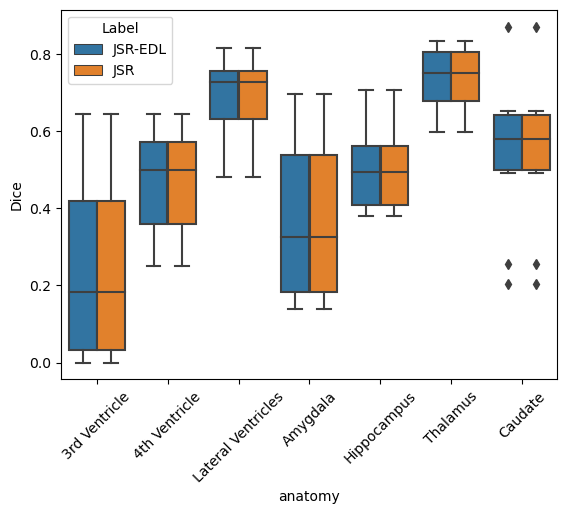

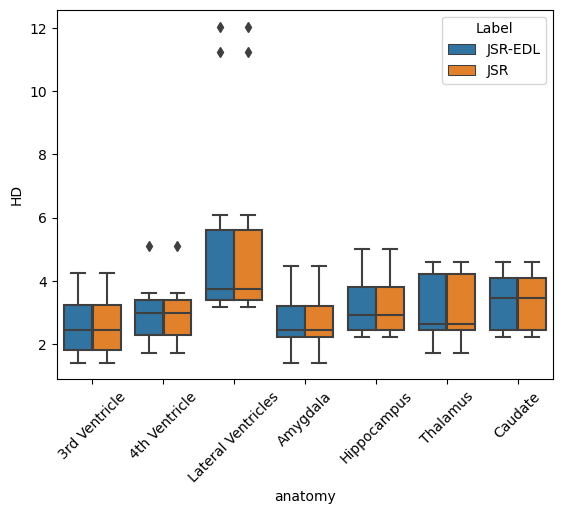

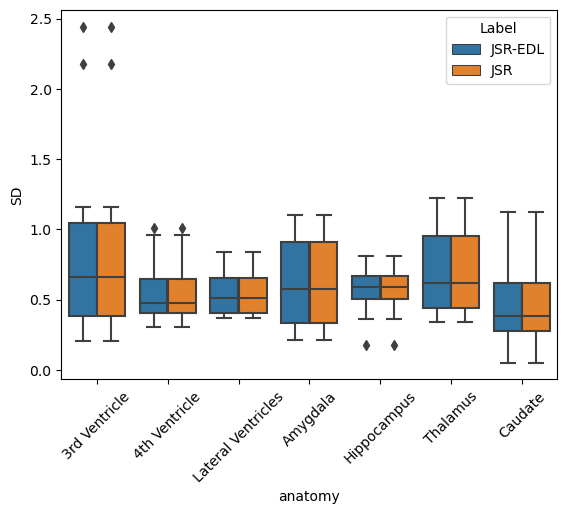

In [35]:
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt
# data1 = pd.read_csv('trained_with_gtCT.csv')
data2 = pd.read_csv('trained_md4_all_sim.csv')
data3 = pd.read_csv('trained_newflow.csv')
# data2 = pd.read_csv('lastlayers_seg.csv')
# data4 = pd.read_csv('lastlayers_sim.csv')

organs = ['3rd Ventricle', '4th Ventricle','Lateral Ventricles', 'Amygdala', 'Hippocampus', 'Thalamus', 'Caudate']
# List of evaluation metrics
metricses = ['Dice', 'HD', 'SD']
plt.style.use('default')
    
# Create box plots for each metric
for i,metric in enumerate(metricses):
    cdf = pd.concat(objs=[data2[metric],data3[[metric,'anatomy']]],axis=1) #],data3[metric],data4[[metric,
    cdf.columns = ['JSR-EDL','JSR','anatomy']
    mdf = pd.melt(cdf, id_vars=['anatomy'], var_name='Label',value_name=metric)
    axs = sns.boxplot(x="anatomy", y=metric, hue="Label", data=mdf)    
    axs.set_xticklabels(axs.get_xticklabels(), rotation=45)
    plt.show()
    

In [9]:
from scipy import stats
def ttest(group1,group2,name):
    _, norm1 = stats.shapiro(group1)
    _, norm2 = stats.shapiro(group2)
    if norm1 <0.05 or norm2<0.05:
        _,p_value = stats.mannwhitneyu(group1, group2)
        if p_value < 0.05:
            print('There is significant difference in '+name)
        else:
            print('There is no significant difference in '+name)
    else:
        _, var = stats.levene(group1,group2)
        if var> 0.05:
            _, p_value = stats.ttest_ind(group1, group2)
            if p_value < 0.05:
                print('There is significant difference in '+name)
            else:
                print('There is no significant difference in '+name)
        else: 
            _, p_value = stats.ttest_ind(group1, group2, equal_var=False)
            if p_value < 0.05:
                print('There is significant difference in '+name)
            else:
                print('There is no significant difference in '+name)
            
            

In [10]:

# data1 = pd.read_csv('base_comp.csv')
# data3 = pd.read_csv('lastlayers_conv.csv')
# data2 = pd.read_csv('lastlayers_seg.csv')
# data4 = pd.read_csv('lastlayers_sim.csv')

for organ in organs:
    print('For '+organ)
    d1 = data3[data3['anatomy']==organ]
    d2 = data2[data2['anatomy']==organ]
    # d3 = data3[data3['anatomy']==organ]
    # d4 = data4[data4['anatomy']==organ]
    for metric in metricses:
        fd = d1[metric]
        sd = d2[metric]
        # td = d3[metric]
        # ed = d4[metric]
        ttest(fd,sd,metric)
        # print('For Conv:')
        # ttest(fd,td,metric)
        # print('For Sim:')
        # ttest(fd,ed,metric)
        

For 3rd Ventricle
There is no significant difference in Dice
There is no significant difference in HD
There is no significant difference in SD
For 4th Ventricle
There is no significant difference in Dice
There is no significant difference in HD
There is no significant difference in SD
For Lateral Ventricles
There is no significant difference in Dice
There is no significant difference in HD
There is no significant difference in SD
For Amygdala
There is no significant difference in Dice
There is no significant difference in HD
There is no significant difference in SD
For Hippocampus
There is no significant difference in Dice
There is no significant difference in HD
There is no significant difference in SD
For Thalamus
There is no significant difference in Dice
There is no significant difference in HD
There is no significant difference in SD
For Caudate
There is no significant difference in Dice
There is no significant difference in HD
There is no significant difference in SD
